# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Clean data one by one

1. Portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Change name of id to offer_id to distinguish from user_id

In [4]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

Create dummy features for channels column

In [5]:
portfolio = pd.concat([portfolio.drop('channels', axis = 1), portfolio.channels.apply(pd.Series).stack().str.get_dummies().sum(level=0)], axis = 1)

In [6]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


2. Profile

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Rename id to user_id to distinguish from offer_id

In [8]:
profile.rename(columns = {'id': 'user_id'}, inplace = True)

Format became_member_on column to datetime

In [9]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [10]:
profile.head()

,age,became_member_on,gender,user_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


3. Transcript

In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Rename id to user_id to distinguish from offer_id

In [12]:
transcript.rename(columns = {'person': 'user_id'}, inplace = True)

In [13]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [14]:
transcript = pd.get_dummies(transcript, columns= ['event'], drop_first = True)

In [15]:
transcript.value.apply(lambda x: x.keys()).value_counts()

(amount)              138952
(offer id)            134001
(offer_id, reward)     33578
(offer id)                 1
(offer_id, reward)         1
(amount)                   1
Name: value, dtype: int64

In [16]:
list_offer_id = []
for i in transcript.value:
    if [*i.keys()][0] in ['offer id', 'offer_id']:
        list_offer_id.append([*i.values()][0])
    else:
        list_offer_id.append(None)

In [17]:
list_amount = []
for i in transcript.value:
    if [*i.keys()][0] in ['amount']:
        list_amount.append([*i.values()][0])
    else:
        list_amount.append(None)

In [18]:
df_offer_id = pd.DataFrame(list_offer_id, columns = ['offer_id'])
df_amount = pd.DataFrame(list_amount, columns = ['amount'])
transcript = pd.concat([transcript.drop('value', axis = 1), df_offer_id, df_amount], axis = 1)

In [19]:
transcript.head()

,user_id,time,event_offer received,event_offer viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Merge three dataframes

In [20]:
df = profile.merge(transcript).merge(portfolio, how = 'left')

In [21]:
df.head()

,age,became_member_on,gender,user_id,income,time,event_offer received,event_offer viewed,event_transaction,offer_id,amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
1,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
3,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
4,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,0,0,1,None,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 19 columns):
age                     306534 non-null int64
became_member_on        306534 non-null datetime64[ns]
gender                  272762 non-null object
user_id                 306534 non-null object
income                  272762 non-null float64
time                    306534 non-null int64
event_offer received    306534 non-null uint8
event_offer viewed      306534 non-null uint8
event_transaction       306534 non-null uint8
offer_id                167581 non-null object
amount                  138953 non-null float64
difficulty              167581 non-null float64
duration                167581 non-null float64
offer_type              167581 non-null object
reward                  167581 non-null float64
email                   167581 non-null float64
mobile                  167581 non-null float64
social                  167581 non-null float64
web                     167581 n

In [23]:
df.dtypes

age                              int64
became_member_on        datetime64[ns]
gender                          object
user_id                         object
income                         float64
time                             int64
event_offer received             uint8
event_offer viewed               uint8
event_transaction                uint8
offer_id                        object
amount                         float64
difficulty                     float64
duration                       float64
offer_type                      object
reward                         float64
email                          float64
mobile                         float64
social                         float64
web                            float64
dtype: object

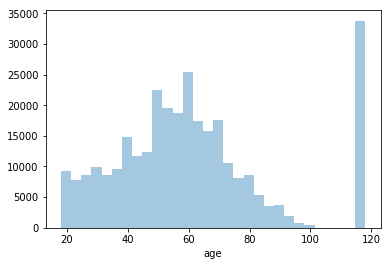

In [24]:
sns.distplot(df.age, bins = 30, kde = False)

In [25]:
#probably one outlier of age happening here
df[df.age>100].head()

,age,became_member_on,gender,user_id,income,time,event_offer received,event_offer viewed,event_transaction,offer_id,amount,difficulty,duration,offer_type,reward,email,mobile,social,web
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
1,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
2,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
3,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
4,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,0,0,1,None,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#remove this age from the dataset
df.shape

(306534, 19)

In [27]:
df = df[df.age<118]

# Prediction

## Data preprocessing

In [28]:
df = pd.get_dummies(df, columns=['offer_type'], drop_first = True)

In [29]:
df = pd.get_dummies(df, columns=['offer_id'], drop_first = True)

In [30]:
df = pd.get_dummies(df, columns=['gender'], drop_first = True)

In [31]:
from datetime import datetime
df['member_since_year'] = df['became_member_on'].apply(lambda x: x.year)
df['member_since_month'] = df['became_member_on'].apply(lambda x: x.month)
df['member_since_day'] = df['became_member_on'].apply(lambda x: x.day)

In [32]:
df.drop('became_member_on', axis = 1, inplace = True)

In [33]:
df.amount.fillna(0, inplace = True)

In [34]:
for i in df.columns[df.dtypes == 'float64']:
    df[i] = df[i].fillna(df[i].mean())

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df.loc[:,'user_id'] = le.fit_transform(df.loc[:,'user_id'])

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X = df[['age', 'user_id', 'income', 'time', 'gender_M', 'gender_O',
        'member_since_year', 'member_since_month', 'member_since_day',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4']]
y = df['event_transaction']

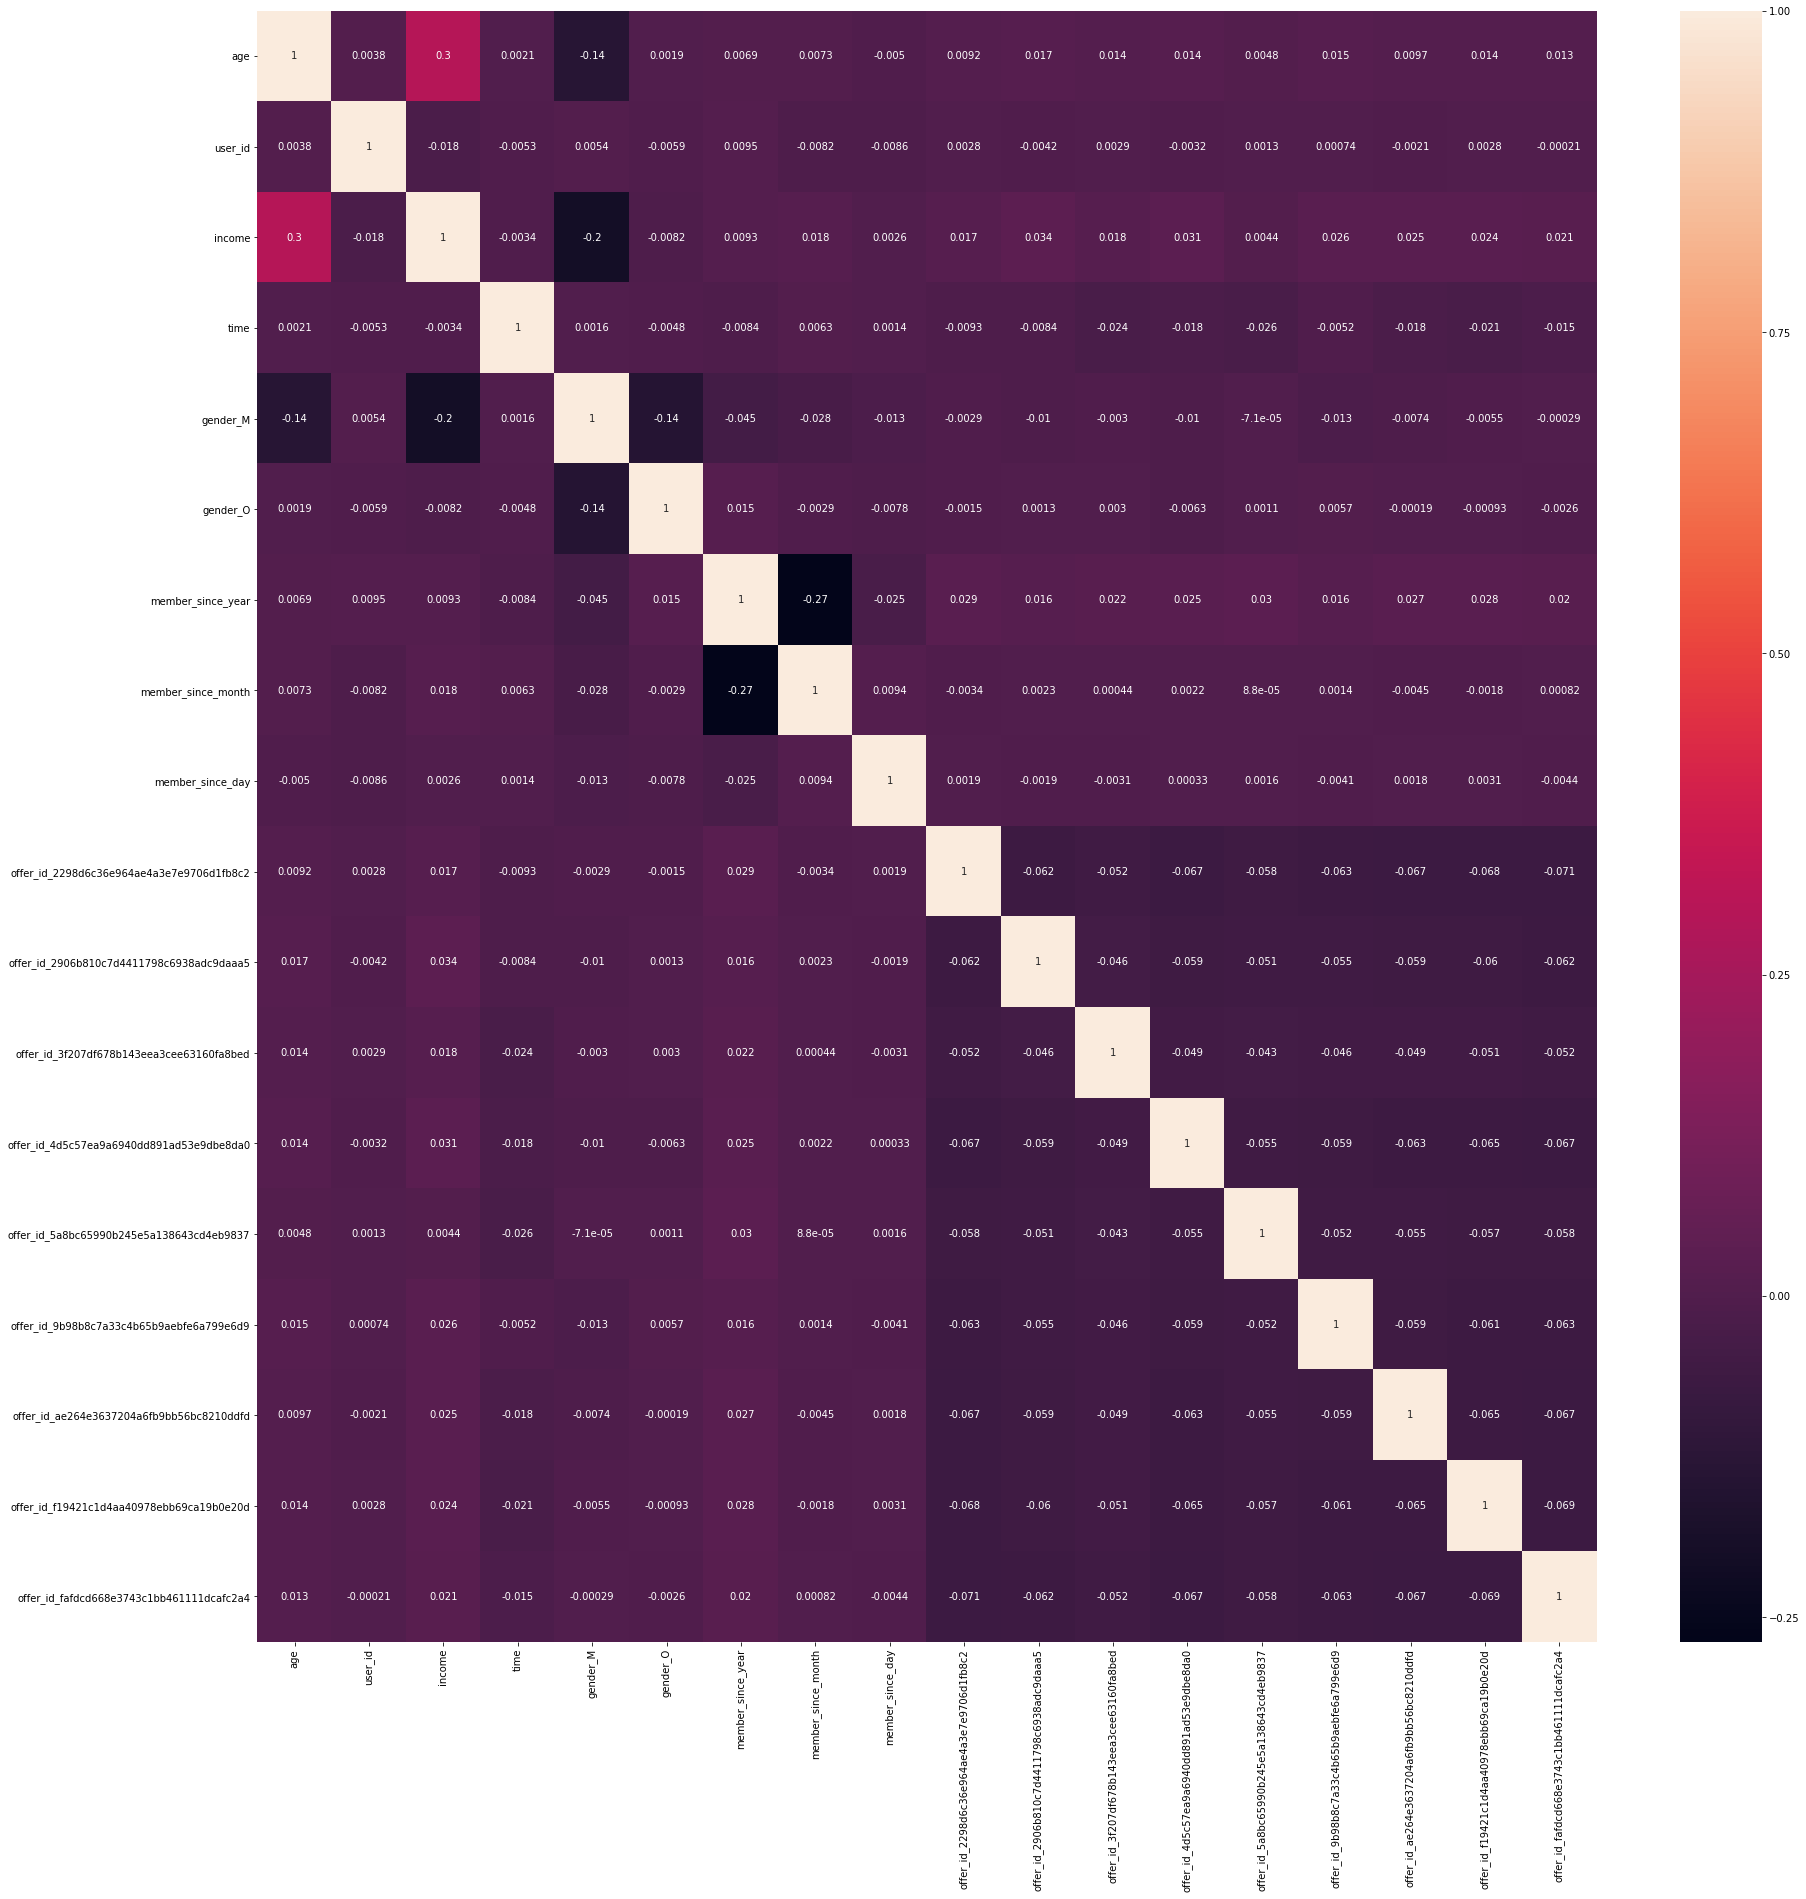

In [38]:
plt.figure(figsize = (30,30))
sns.heatmap(df[['age', 'user_id', 'income', 'time', 'gender_M', 'gender_O',
        'member_since_year', 'member_since_month', 'member_since_day',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4']].corr(), annot = True)

## Implementation

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     43724
          1       0.95      0.93      0.94     38105

avg / total       0.95      0.95      0.95     81829

[[42051  1673]
 [ 2682 35423]]


## Refinement

GridSearchCV

In [40]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [41]:
param_grid = [{'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 3, 4]}]

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
cv = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5)

In [44]:
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
print(cv.best_params_)

print(cv.best_score_)

{'min_samples_leaf': 4, 'min_samples_split': 4}
0.957241545464


In [46]:
enhanced_predict = cv.predict(X_test)

In [47]:
print(classification_report(enhanced_predict, y_test))
print(confusion_matrix(enhanced_predict, y_test))

             precision    recall  f1-score   support

          0       0.93      0.99      0.96     41800
          1       0.99      0.92      0.95     40029

avg / total       0.96      0.96      0.96     81829

[[41519   281]
 [ 3214 36815]]


In [63]:
feature_importance = pd.DataFrame(cv.best_estimator_.feature_importances_, X_test.columns, columns = ['feature_importance'])

In [65]:
feature_importance['feature_importance'].sort_values()

gender_O                                     0.000283
gender_M                                     0.001117
member_since_month                           0.005838
member_since_year                            0.006730
member_since_day                             0.008867
age                                          0.010698
user_id                                      0.012656
income                                       0.015543
time                                         0.064574
offer_id_3f207df678b143eea3cee63160fa8bed    0.066939
offer_id_2906b810c7d4411798c6938adc9daaa5    0.089987
offer_id_f19421c1d4aa40978ebb69ca19b0e20d    0.090977
offer_id_fafdcd668e3743c1bb461111dcafc2a4    0.096925
offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2    0.101772
offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9    0.103864
offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0    0.104458
offer_id_5a8bc65990b245e5a138643cd4eb9837    0.106151
offer_id_ae264e3637204a6fb9bb56bc8210ddfd    0.112620
Name: feature_importance, dt